# Using Transfer Learning

## Load InceptionV3

In [1]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [2]:
## load weights

local_weights_file = 'inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
    layer.trainable= False
  
pre_trained_model.summary()


Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [3]:
## get last layers

last_layer= pre_trained_model.get_layer('mixed7')
print('Last Layer output shape: ', last_layer.output_shape)
last_output= last_layer.output
last_output

Last Layer output shape:  (None, 7, 7, 768)


<tf.Tensor 'mixed7/Identity:0' shape=(None, 7, 7, 768) dtype=float32>

In [4]:
## input layer

pre_trained_model.input

<tf.Tensor 'input_1:0' shape=(None, 150, 150, 3) dtype=float32>

In [5]:
## add layers according to purpose, here cats and dogs classification

from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import layers
from tensorflow.keras.models import Model


x= layers.Flatten()(last_output)
x=layers.Dense(1024, activation='relu')(x)
x=layers.Dropout(0.2)(x)
x=layers.Dense(1, activation='sigmoid')(x)

model= Model(pre_trained_model.input, x)

model.compile(optimizer=RMSprop(lr=0.0001),
             loss='binary_crossentropy',
             metrics=['acc'])



In [6]:
## image augmenation for better results and reduce overfitting

train_dir='cats_and_dogs_filtered/train'
test_dir='cats_and_dogs_filtered/validation'
train_cats_dir='cats_and_dogs_filtered/train/cats'
train_dogs_dir='cats_and_dogs_filtered/train/dogs'

import os
train_cat_fnames = os.listdir( train_cats_dir )
train_dog_fnames = os.listdir( train_dogs_dir )

print(train_cat_fnames[:10])
print(train_dog_fnames[:10])


from tensorflow.keras.preprocessing.image import ImageDataGenerator 


traindata = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

testdata = ImageDataGenerator(rescale=1./255)


train_generator = traindata.flow_from_directory(train_dir, 
                                                class_mode='binary',
                                                batch_size=20,
                                                target_size=(150,150))

validation_generator= testdata.flow_from_directory(test_dir, 
                                                  class_mode='binary',
                                                  batch_size=20,
                                                  target_size=(150,150))

['cat.0.jpg', 'cat.1.jpg', 'cat.10.jpg', 'cat.100.jpg', 'cat.101.jpg', 'cat.102.jpg', 'cat.103.jpg', 'cat.104.jpg', 'cat.105.jpg', 'cat.106.jpg']
['dog.0.jpg', 'dog.1.jpg', 'dog.10.jpg', 'dog.100.jpg', 'dog.101.jpg', 'dog.102.jpg', 'dog.103.jpg', 'dog.104.jpg', 'dog.105.jpg', 'dog.106.jpg']
Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [7]:
## fit and train model

history = model.fit_generator(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            epochs = 20,
            validation_steps = 50,
            verbose = 1)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 100 steps, validate for 50 steps
Epoch 1/20
100/100 [==============================] - 332s 3s/step - loss: 0.5136 - acc: 0.7570 - val_loss: 0.4274 - val_acc: 0.8820
Epoch 2/20
100/100 [==============================] - 221s 2s/step - loss: 0.3853 - acc: 0.8325 - val_loss: 0.2291 - val_acc: 0.9430
Epoch 3/20
100/100 [==============================] - 281s 3s/step - loss: 0.3722 - acc: 0.8370 - val_loss: 0.2408 - val_acc: 0.9400
Epoch 4/20
100/100 [==============================] - 334s 3s/step - loss: 0.3156 - acc: 0.8620 - val_loss: 0.3997 - val_acc: 0.9210
Epoch 5/20
100/100 [==============================] - 338s 3s/step - loss: 0.3258 - acc: 0.8625 - val_loss: 0.6269 - val_acc: 0.9060
Epoch 6/20
100/100 [==============================] - 295s 3s/step - loss: 0.2941 - acc: 0.8750 - val_loss: 0.3043 - val_acc: 0.9490
Epoch 7/20
100/100 [=============

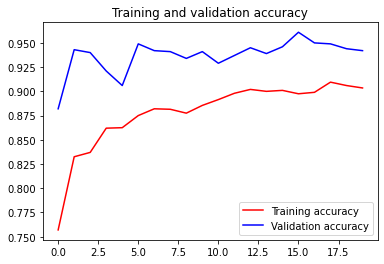

<Figure size 432x288 with 0 Axes>

In [8]:
## ploting accuracy and loss per epoch

import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()